# 주제 : 브라질 이커머스 소비 트렌드 파악
1. 분기별로 무관하게 팔리는 상품이 있는가?
2. 17년도 18년도 1, 2, 3 분기에서 비슷한 흐름이 있는가?
3. 배송기간과 취소 사이의 상관관계    ex. 취소한 이유 : 가정 - 배송기간이 길어서
4. 리뷰와 배송시간 사이의 상관관계
5. 인기 제품 카테고리의 상품의 평균 평점이 더 높은가?

# 전처리
- 데이터셋 합치기(join)
- order_status = cancel, unavailable 삭제

In [1]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# 한글폰트 설정
import os
if os.name== "posix":
    plt.rc("font", family="AppleGothic")
else:
    plt.rc("font", family="Malgun Gothic")

In [2]:
# 데이터셋 불러오기
orders = pd.read_csv('olist_orders_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
category_name = pd.read_csv('product_category_name_translation.csv')

In [3]:
# 데이터셋 조인(merge)
df = pd.merge(orders, order_items, left_on='order_id', right_on='order_id', how='left')
df = pd.merge(df, products, left_on='product_id', right_on='product_id', how='left')
df = pd.merge(df, category_name, left_on='product_category_name', right_on='product_category_name', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113425 entries, 0 to 113424
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113425 non-null  object 
 1   customer_id                    113425 non-null  object 
 2   order_status                   113425 non-null  object 
 3   order_purchase_timestamp       113425 non-null  object 
 4   order_approved_at              113264 non-null  object 
 5   order_delivered_carrier_date   111457 non-null  object 
 6   order_delivered_customer_date  110196 non-null  object 
 7   order_estimated_delivery_date  113425 non-null  object 
 8   order_item_id                  112650 non-null  float64
 9   product_id                     112650 non-null  object 
 10  seller_id                      112650 non-null  object 
 11  shipping_limit_date            112650 non-null  object 
 12  price                         

In [4]:
# cancel, unavailable 삭제
condition = (df['order_status']=='canceled') | (df['order_status']=='unavailable')
df = df[~condition]

In [5]:
df.shape

(112109, 23)

# 분기에 상관없이 항상 인기 많은(잘 팔리는) 제품 

In [6]:
top10_product = pd.DataFrame(df.groupby(['product_category_name_english'])['order_item_id'].sum().sort_values(ascending=False).reset_index().head(10))
top10_product

,product_category_name_english,order_item_id
0,bed_bath_table,13647.0
1,furniture_decor,11471.0
2,health_beauty,11044.0
3,sports_leisure,9877.0
4,computers_accessories,9805.0
5,housewares,8977.0
6,watches_gifts,6572.0
7,garden_tools,5839.0
8,telephony,5141.0
9,auto,4838.0


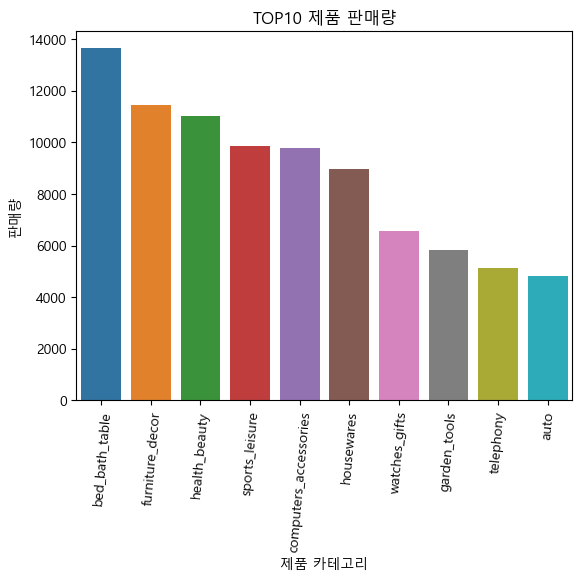

In [7]:
sns.barplot(x='product_category_name_english', y='order_item_id', data=top10_product)
plt.xticks(rotation=85)
plt.xlabel('제품 카테고리')
plt.ylabel('판매량')
plt.title('TOP10 제품 판매량')
plt.show()

In [8]:
# 날짜 데이터 수정

# datetime으로 타입 변경
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# 분기(Q)를 나타내는 컬럼 추가
df['4Q'] = df['order_purchase_timestamp'].dt.to_period("Q")

# 주문(년-월) 컬럼 추가
df['year-month'] = df['order_purchase_timestamp'].dt.strftime('%Y-%m')

### 월별 많이 팔리는 제품 카테고리 상위 5개 비교

In [9]:
# 월별, 카테고리별 제품 판매량(그룹화) + 판매량순 정렬
monthly_count = pd.DataFrame(df.groupby(['year-month','product_category_name_english'])['order_item_id'].count().reset_index())
monthly_count = monthly_count.sort_values(['year-month','order_item_id'],ascending=[True,False])
monthly_count

,year-month,product_category_name_english,order_item_id
1,2016-09,health_beauty,3
0,2016-09,furniture_decor,2
20,2016-10,furniture_decor,67
22,2016-10,health_beauty,46
27,2016-10,perfumery,29
...,...,...,...
1219,2018-08,fashion_underwear_beach,2
1197,2018-08,books_imported,1
1212,2018-08,dvds_blu_ray,1
1218,2018-08,fashion_sport,1


In [10]:
# 월별로 많이 팔리는 제품 5개씩 출력
monthly_count_5 = monthly_count.groupby(['year-month']).head(5)
monthly_count_5 

,year-month,product_category_name_english,order_item_id
1,2016-09,health_beauty,3
0,2016-09,furniture_decor,2
20,2016-10,furniture_decor,67
22,2016-10,health_beauty,46
27,2016-10,perfumery,29
...,...,...,...
1195,2018-08,bed_bath_table,658
1232,2018-08,housewares,625
1246,2018-08,sports_leisure,473
1224,2018-08,furniture_decor,432


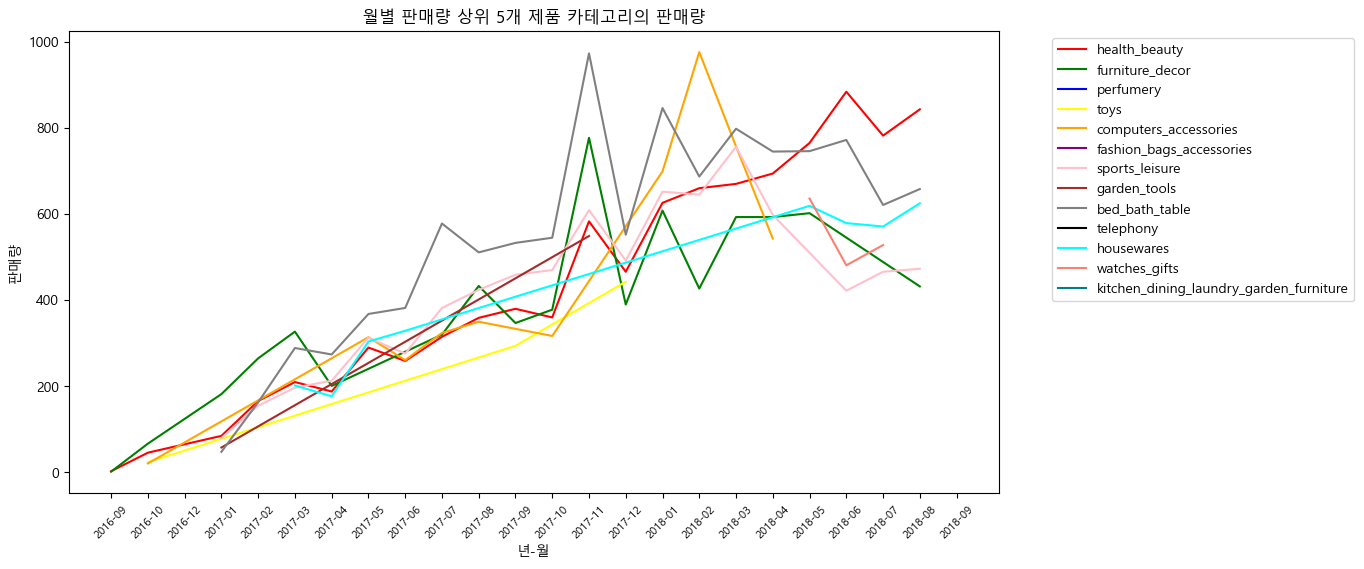

In [11]:
# 선 그래프 그리기
plt.figure(figsize=(12, 6)) # 그래프 사이즈 지정
plt.xticks(size=8, rotation=45)

custom_palette = ['red','green','blue','yellow','orange','purple','pink','brown','gray','black','cyan', 'Salmon', 'teal']
sns.lineplot(x='year-month',y='order_item_id',data=monthly_count_5,hue='product_category_name_english', palette=custom_palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('월별 판매량 상위 5개 제품 카테고리의 판매량')
plt.xlabel('년-월')
plt.ylabel('판매량')
plt.show()

- 월별 판매량의 차이가 존재하기 때문에, 그래프 선이 계속해서 존재하는 것은 지속적으로 많이 팔리는 제품이라고 볼 수 있음.
- 특정 달에만 팔린 제품을 보고, 그 시기에만 인기가 있었던 제품으로도 해석할 수 있음.

### 분기별 많이 팔리는 제품 카테고리 상위 5개 비교

In [12]:
# 분기별, 제품카테고리별 판매량(그룹화) + 판매량순 정렬
quarter_count = pd.DataFrame(df.groupby(['4Q','product_category_name_english'])['order_item_id'].count().reset_index())
quarter_count = quarter_count.sort_values(['4Q','order_item_id'],ascending=[True,False])
quarter_count

,4Q,product_category_name_english,order_item_id
1,2016Q3,health_beauty,3
0,2016Q3,furniture_decor,2
20,2016Q4,furniture_decor,67
22,2016Q4,health_beauty,46
27,2016Q4,perfumery,29
...,...,...,...
473,2018Q3,home_comfort_2,3
453,2018Q3,dvds_blu_ray,2
462,2018Q3,flowers,2
459,2018Q3,fashion_sport,1


In [13]:
quarter_count.info()

<class 'pandas.core.frame.DataFrame'>
Index: 495 entries, 1 to 468
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype        
---  ------                         --------------  -----        
 0   4Q                             495 non-null    period[Q-DEC]
 1   product_category_name_english  495 non-null    object       
 2   order_item_id                  495 non-null    int64        
dtypes: int64(1), object(1), period[Q-DEC](1)
memory usage: 15.5+ KB


In [14]:
# 4Q : 문자열 타입으로 변경
quarter_count['4Q'] = quarter_count['4Q'].astype('str')

In [15]:
# 분기별로 많이 팔리는 제품 카테고리 5개씩 출력
quarter_count_5 = quarter_count.groupby(['4Q']).head(5)
quarter_count_5 

,4Q,product_category_name_english,order_item_id
1,2016Q3,health_beauty,3
0,2016Q3,furniture_decor,2
20,2016Q4,furniture_decor,67
22,2016Q4,health_beauty,46
27,2016Q4,perfumery,29
31,2016Q4,toys,24
9,2016Q4,computers_accessories,21
64,2017Q1,furniture_decor,774
39,2017Q1,bed_bath_table,500
67,2017Q1,health_beauty,461


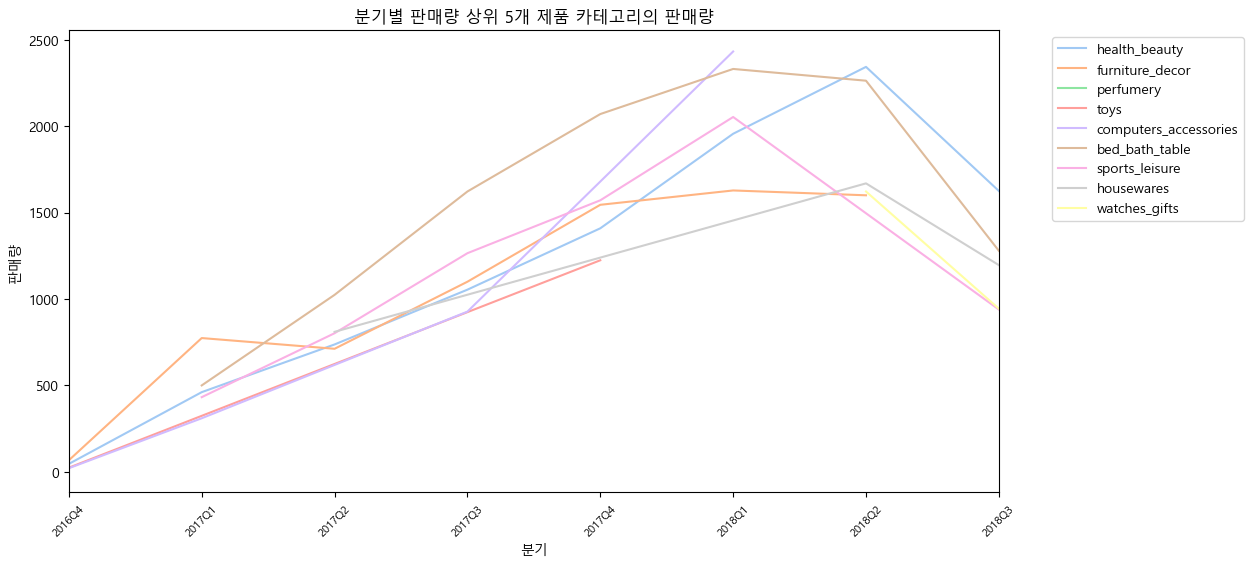

In [16]:
# 선 그래프 그리기
plt.figure(figsize=(12, 6)) # 그래프 사이즈 지정
plt.xticks(size=8, rotation=45)
sns.set_palette('pastel')

sns.lineplot(x='4Q', y='order_item_id',data=quarter_count_5, hue='product_category_name_english')
plt.xlim('2016Q4', '2018Q3')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('분기별 판매량 상위 5개 제품 카테고리의 판매량')
plt.xlabel('분기')
plt.ylabel('판매량')
plt.show()

# 분기별 흐름 파악

### 분기별 카테고리별 판매량

In [17]:
# 분기별, 상품카테고리별 판매량(그룹화)
count_4Q_ca = pd.DataFrame(df.groupby(['4Q','product_category_name_english'])['order_item_id'].sum().reset_index())
count_4Q_ca

,4Q,product_category_name_english,order_item_id
0,2016Q3,furniture_decor,3.0
1,2016Q3,health_beauty,6.0
2,2016Q4,air_conditioning,18.0
3,2016Q4,audio,2.0
4,2016Q4,auto,9.0
...,...,...,...
490,2018Q3,sports_leisure,1073.0
491,2018Q3,stationery,405.0
492,2018Q3,telephony,597.0
493,2018Q3,toys,358.0


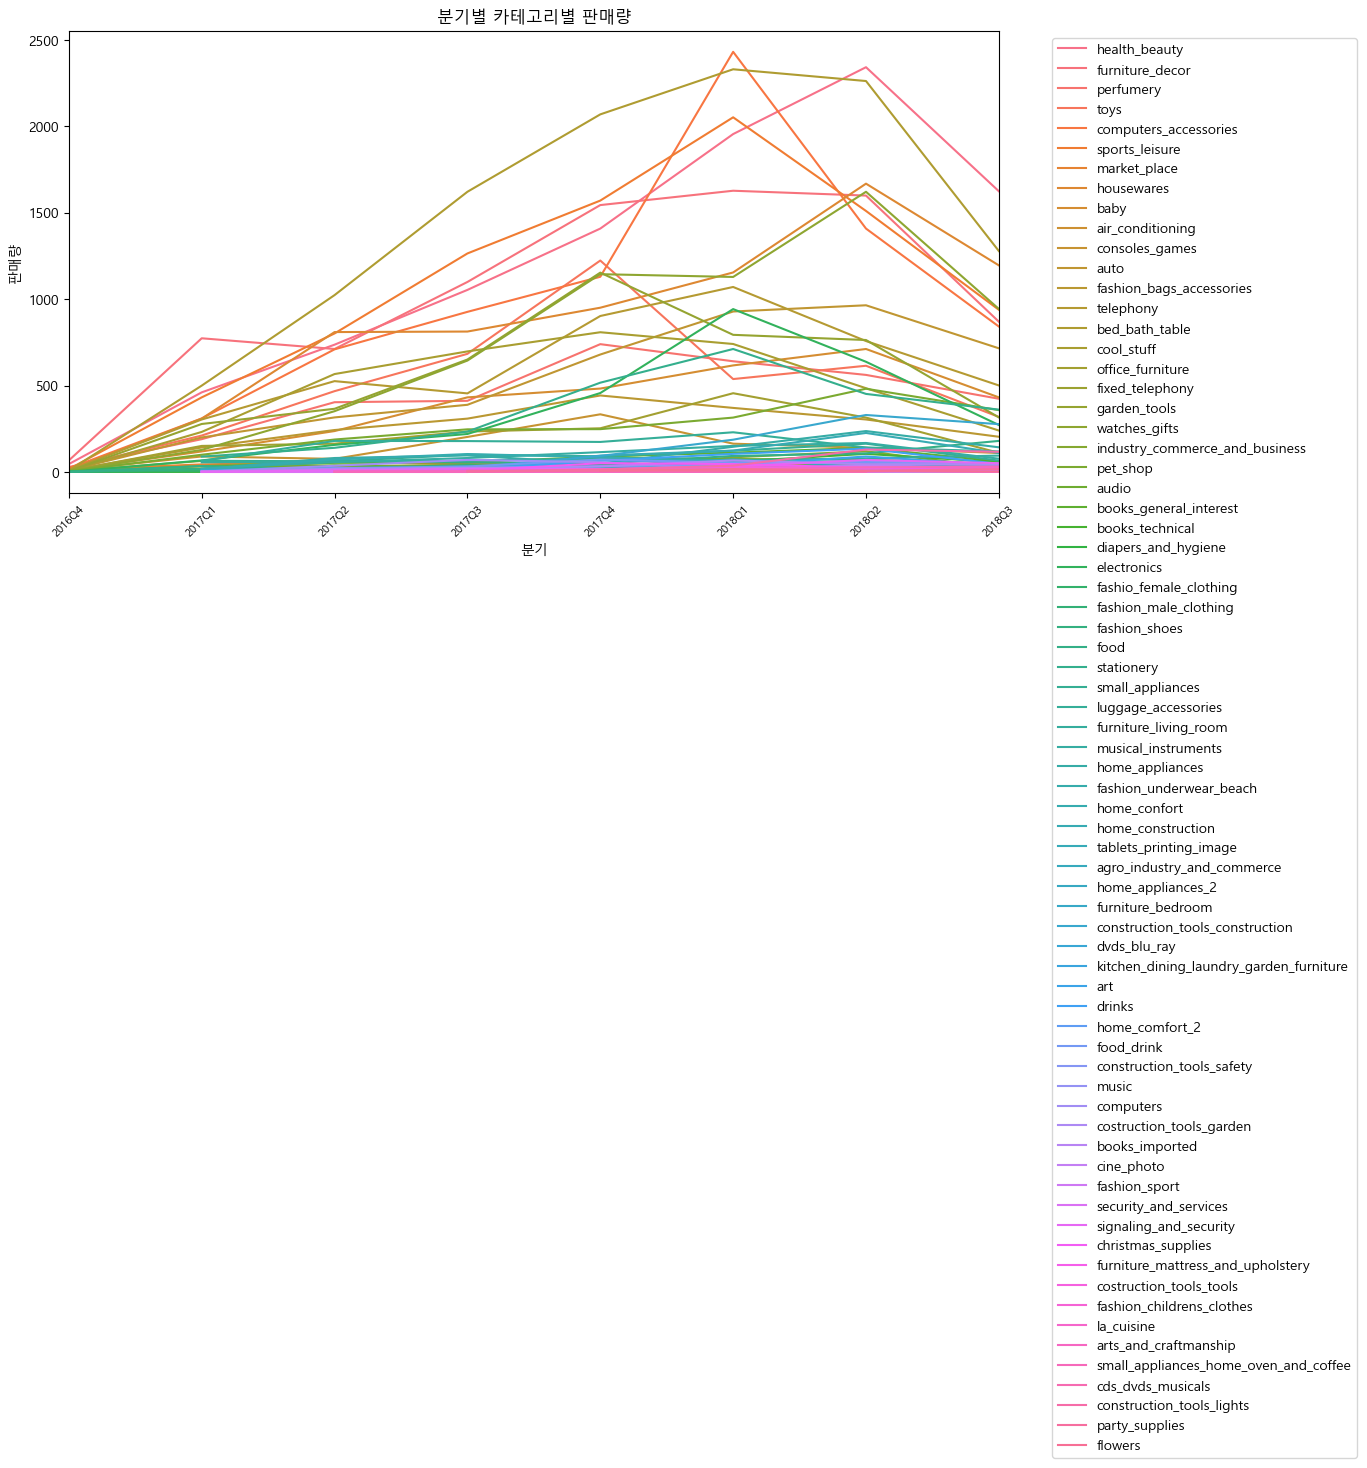

In [18]:
# 선 그래프 그리기
plt.figure(figsize=(12, 6))
plt.xticks(size=8, rotation=45)

sns.lineplot(x='4Q', y='order_item_id',data=quarter_count, hue='product_category_name_english')
plt.xlim('2016Q4', '2018Q3')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('분기별 카테고리별 판매량')
plt.xlabel('분기')
plt.ylabel('판매량')
plt.show()

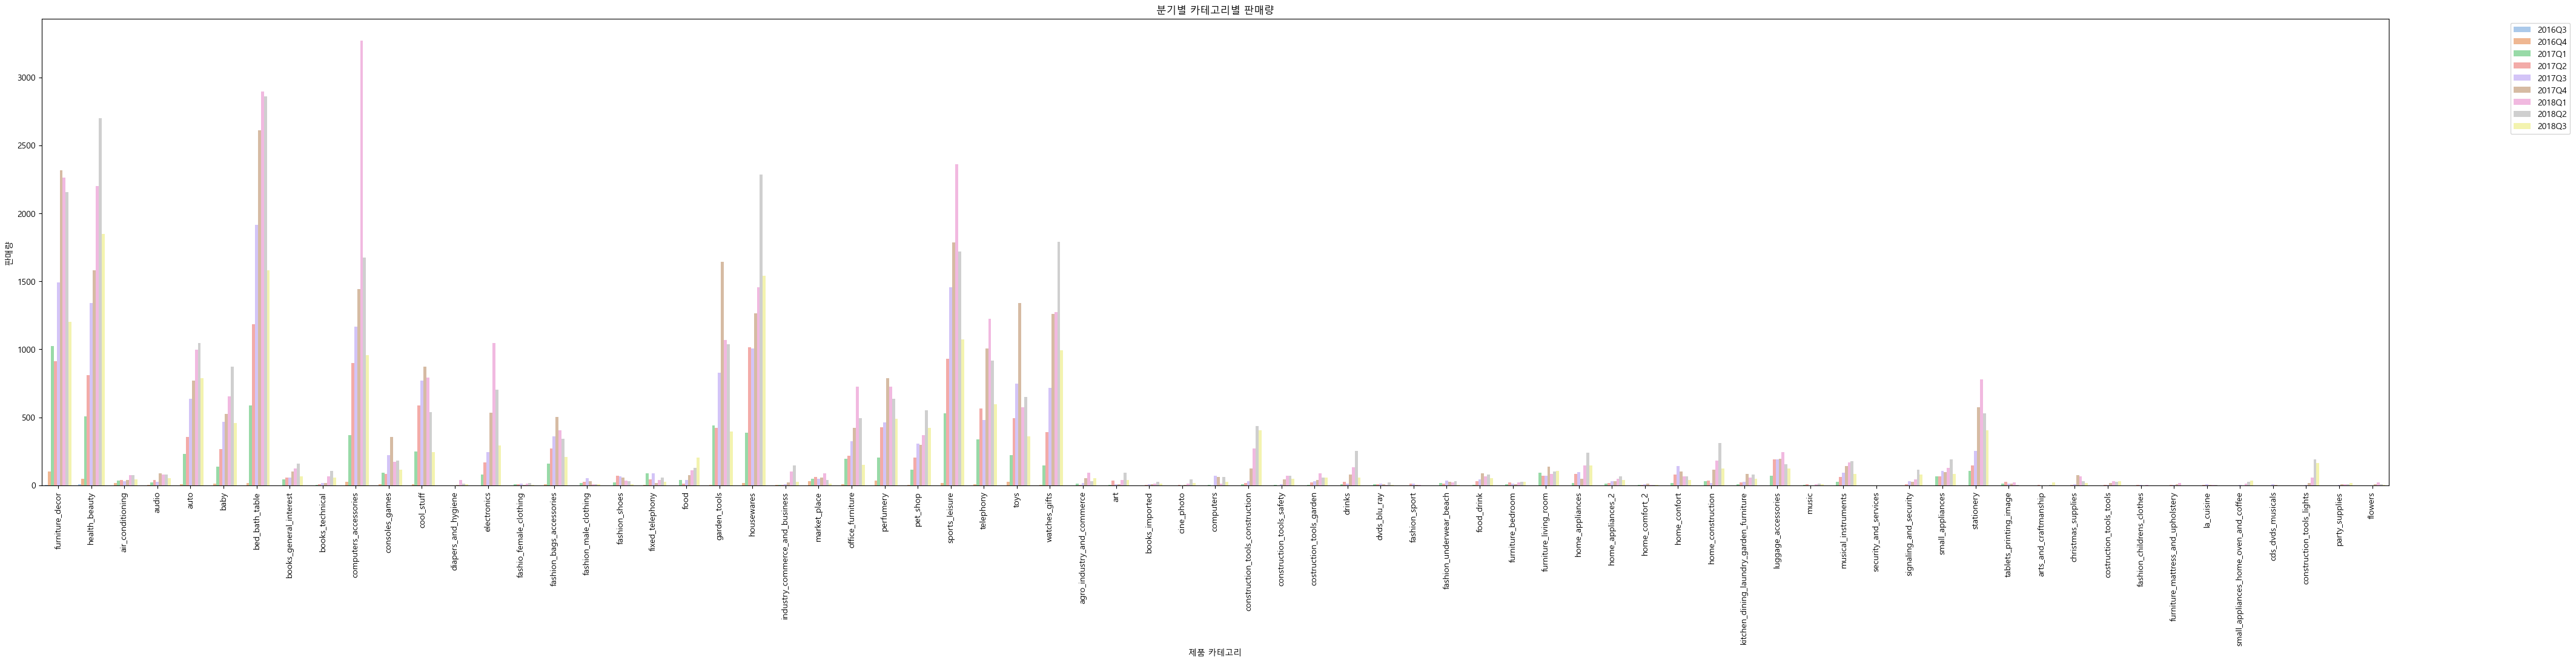

In [19]:
# 카테고리를 x축으로 설정 
plt.figure(figsize=(50, 10)) 
sns.barplot(y='order_item_id',x='product_category_name_english',hue='4Q', data=count_4Q_ca)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('분기별 카테고리별 판매량')
plt.xlabel('제품 카테고리')
plt.ylabel('판매량')
plt.xticks(rotation=90)
plt.show()

### 분기별 비교
1. 2017 1분기 vs 2018 1분기
2. 2017 2분기 vs 2018 2분기
3. 2017 3분기 vs 2018 3분기
4. 2017 4분기 vs 2016 4분기

In [20]:
# 1분기 데이터
Q1 = count_4Q_ca[(count_4Q_ca['4Q'] == '2017Q1') | (count_4Q_ca['4Q'] == '2018Q1')]
Q1 = pd.DataFrame(Q1.groupby(['product_category_name_english'])['order_item_id'].sum().reset_index())
# 2분기 데이터
Q2 = count_4Q_ca[(count_4Q_ca['4Q'] == '2017Q2') | (count_4Q_ca['4Q'] == '2018Q2')]
Q2 = pd.DataFrame(Q2.groupby(['product_category_name_english'])['order_item_id'].sum().reset_index())
# 3분기 데이터
Q3 = count_4Q_ca[(count_4Q_ca['4Q'] == '2017Q3') | (count_4Q_ca['4Q'] == '2018Q3')]
Q3 = pd.DataFrame(Q3.groupby(['product_category_name_english'])['order_item_id'].sum().reset_index())

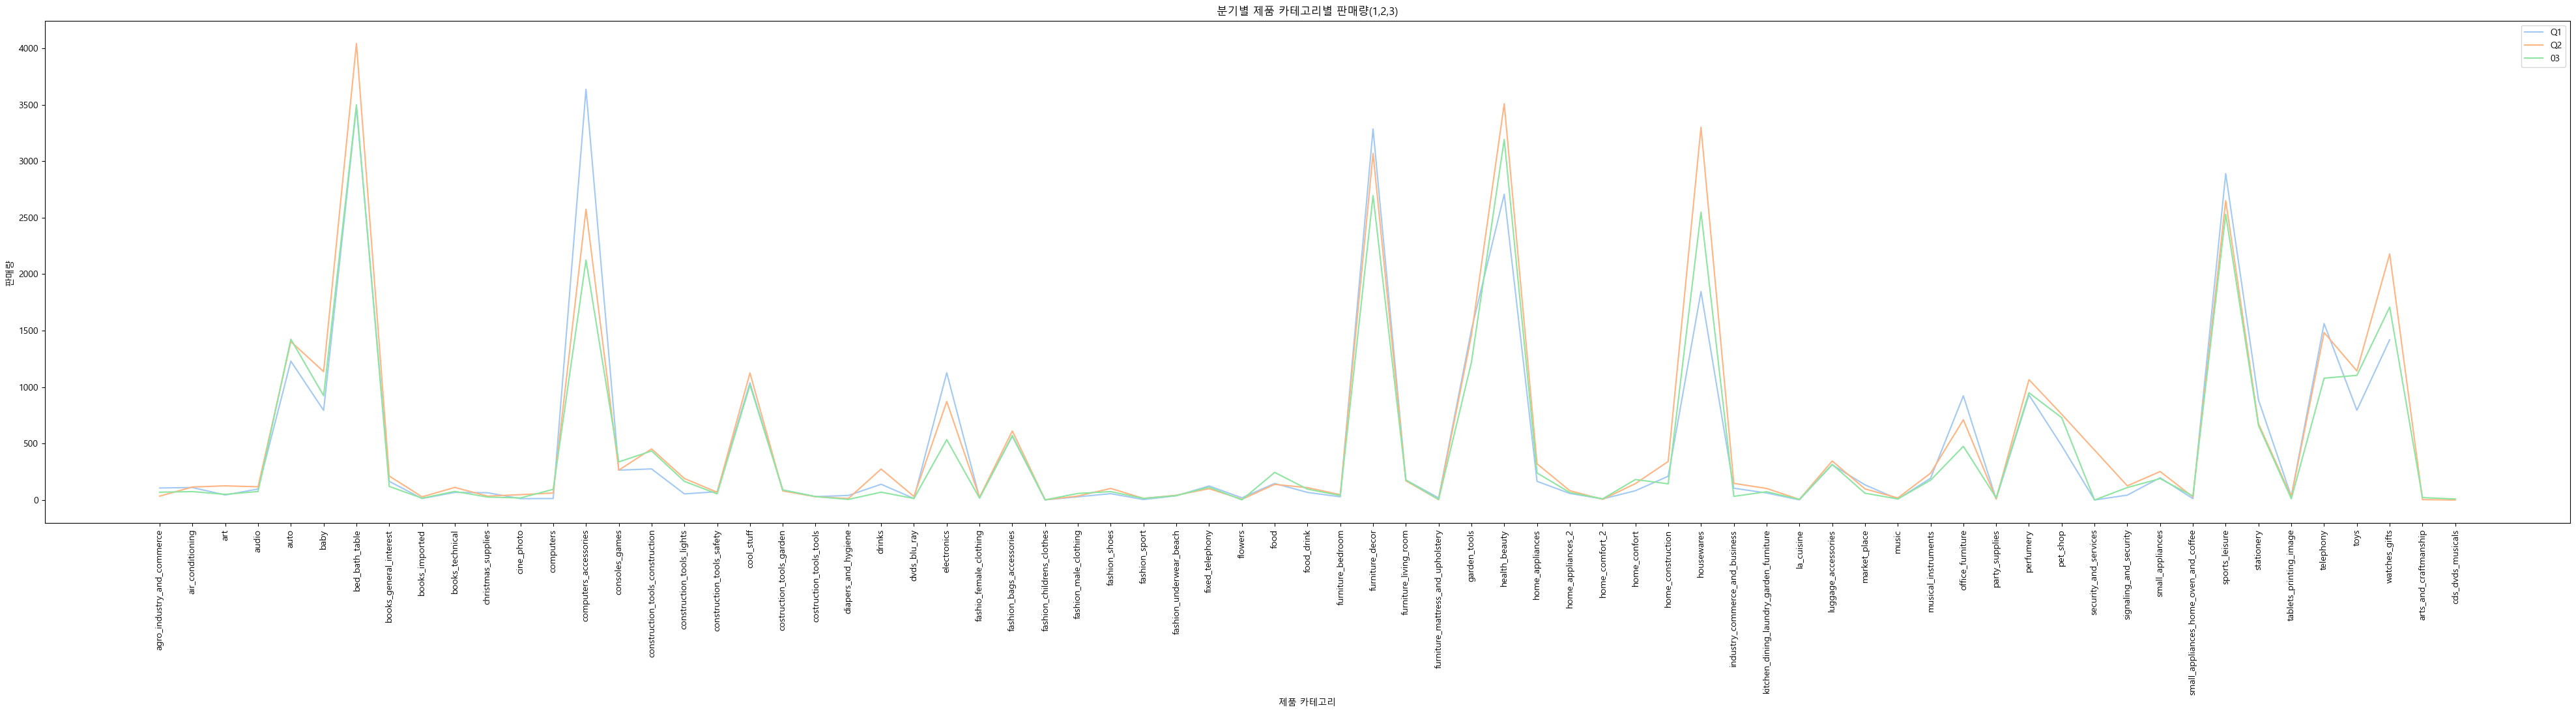

In [21]:
plt.figure(figsize=(50, 10)) 
sns.lineplot(data=Q1, x='product_category_name_english', y='order_item_id', label='Q1')
sns.lineplot(data=Q2, x='product_category_name_english', y='order_item_id', label='Q2')
sns.lineplot(data=Q3, x='product_category_name_english', y='order_item_id', label='03')
plt.legend()
plt.title('분기별 제품 카테고리별 판매량(1,2,3)')
plt.xticks(rotation=90)
plt.xlabel('제품 카테고리')
plt.ylabel('판매량')
plt.show()

=> 분기마다 많이 팔리는 상품이 있다기 보다는, 항상 많이 팔리는 제품이 다른 분기에도 항상 많이 팔린다.

### 1분기

In [22]:
# 2017 1분기 vs 2018 1분기
cond1 = (count_4Q_ca['4Q'] == '2017Q1')| (count_4Q_ca['4Q'] == '2018Q1')
q_01 = count_4Q_ca[cond1]
q_01

,4Q,product_category_name_english,order_item_id
33,2017Q1,agro_industry_and_commerce,13.0
34,2017Q1,air_conditioning,35.0
35,2017Q1,art,5.0
36,2017Q1,audio,20.0
37,2017Q1,auto,231.0
...,...,...,...
355,2018Q1,stationery,781.0
356,2018Q1,tablets_printing_image,21.0
357,2018Q1,telephony,1226.0
358,2018Q1,toys,574.0


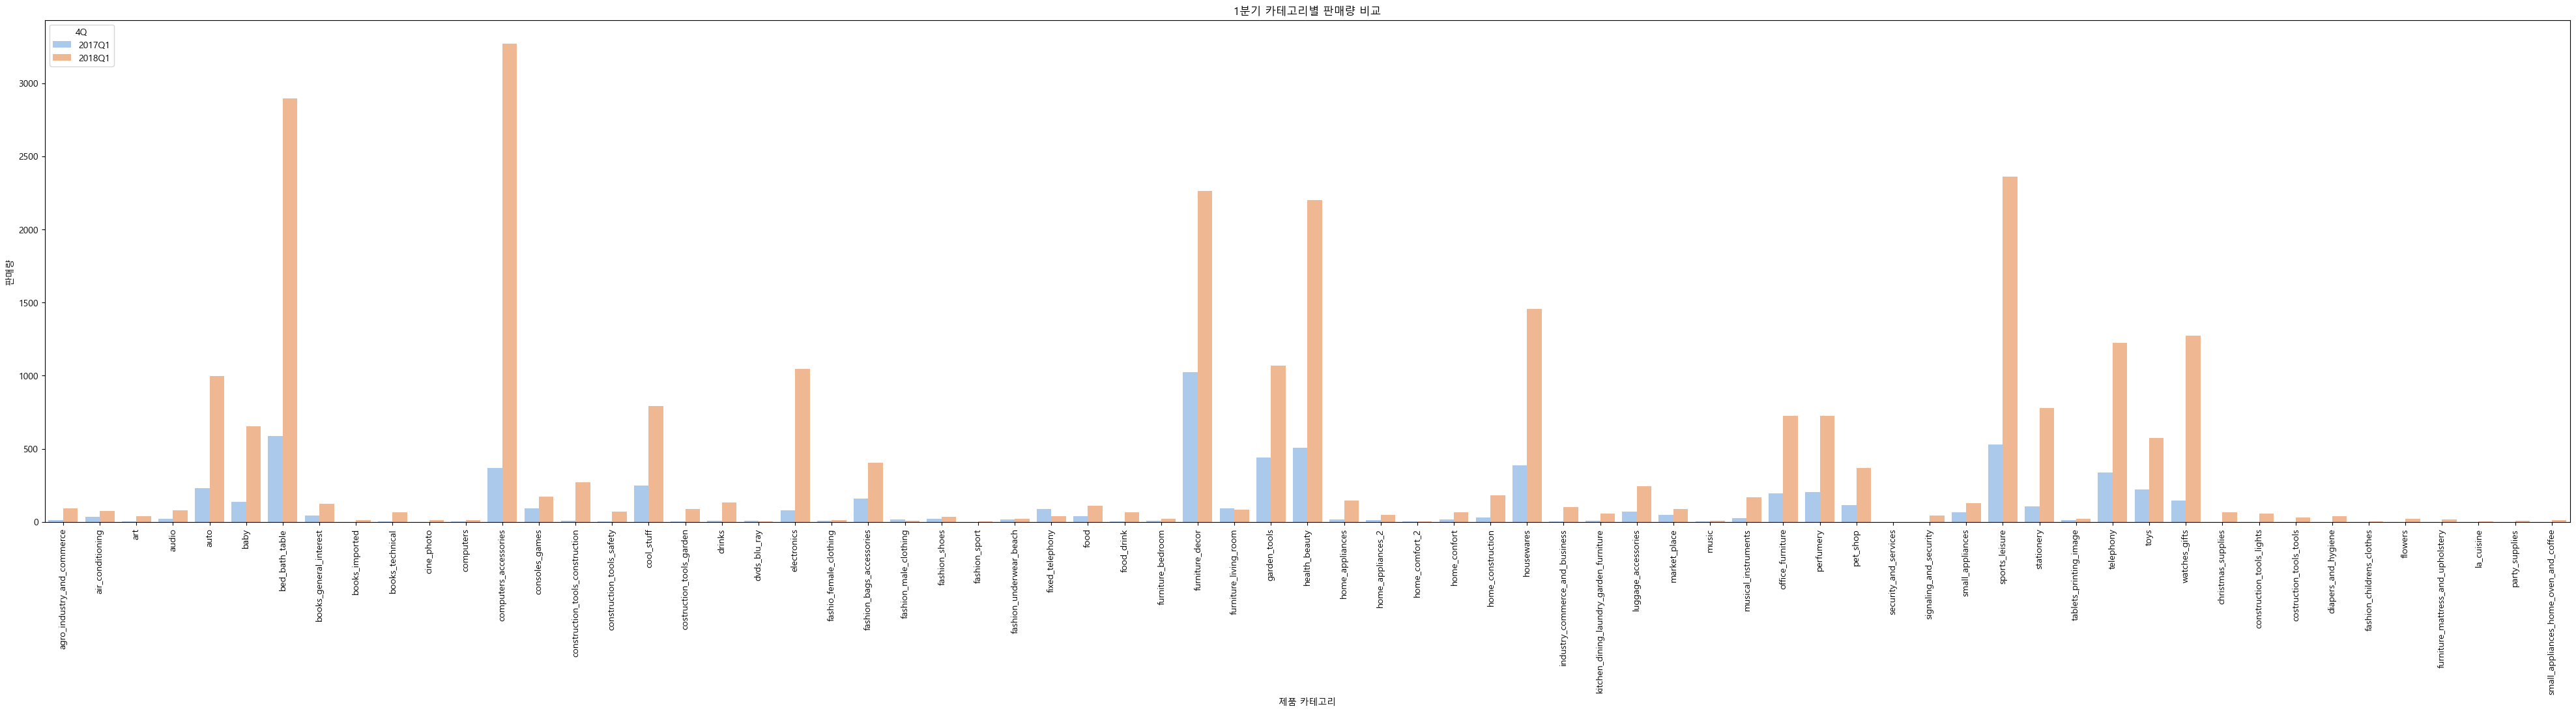

In [23]:
plt.figure(figsize=(50, 10)) 
sns.barplot(data=q_01,x='product_category_name_english',y='order_item_id',hue='4Q')
plt.title('1분기 카테고리별 판매량 비교')
plt.xticks(rotation=90)
plt.xlabel('제품 카테고리')
plt.ylabel('판매량')
plt.show()

### 2분기

In [24]:
# 2017 2분기 vs 2018 2분기
cond2 = (count_4Q_ca['4Q'] == '2017Q2')| (count_4Q_ca['4Q'] == '2018Q2')
q_02 = count_4Q_ca[cond2]
q_02

,4Q,product_category_name_english,order_item_id
92,2017Q2,agro_industry_and_commerce,5.0
93,2017Q2,air_conditioning,41.0
94,2017Q2,art,34.0
95,2017Q2,arts_and_craftmanship,2.0
96,2017Q2,audio,41.0
...,...,...,...
424,2018Q2,stationery,531.0
425,2018Q2,tablets_printing_image,3.0
426,2018Q2,telephony,918.0
427,2018Q2,toys,651.0


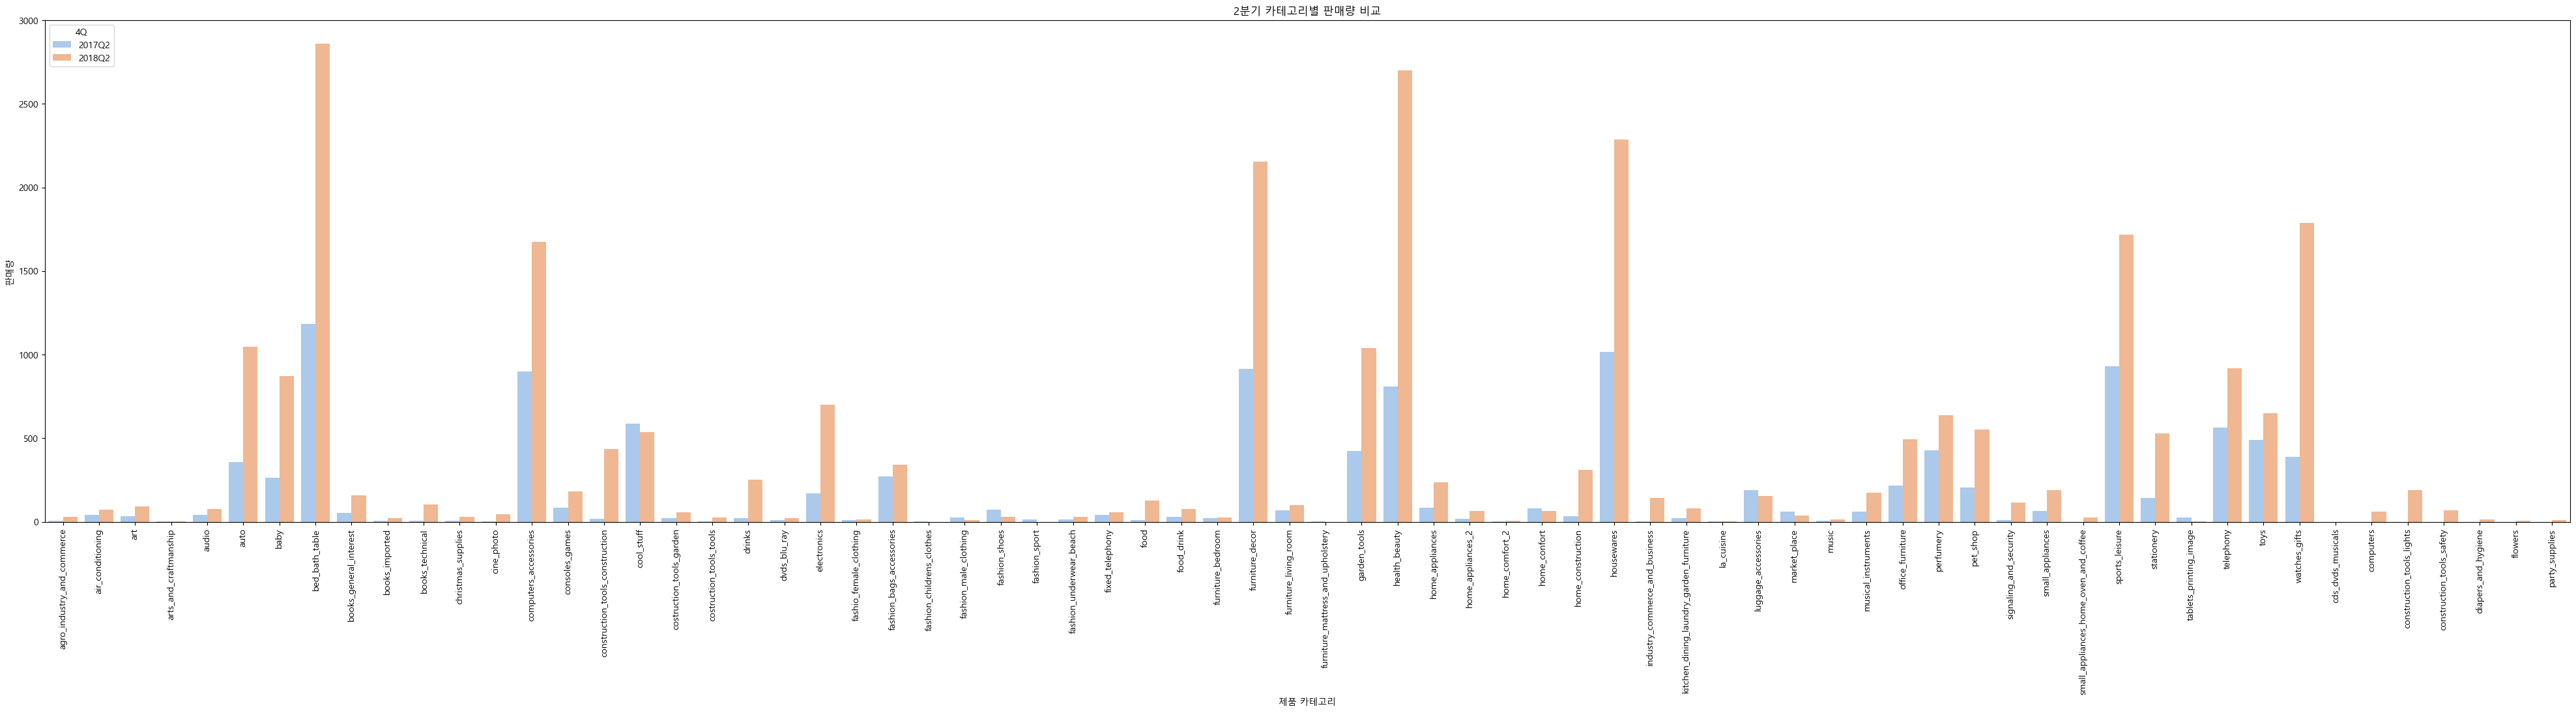

In [25]:
plt.figure(figsize=(50, 10)) 
sns.barplot(data=q_02,x='product_category_name_english',y='order_item_id',hue='4Q')
plt.title('2분기 카테고리별 판매량 비교')
plt.xticks(rotation=90)
plt.xlabel('제품 카테고리')
plt.ylabel('판매량')
plt.show()

### 3분기

In [26]:
# 2017 3분기 vs 2018 3분기
cond3 = (count_4Q_ca['4Q'] == '2017Q3')| (count_4Q_ca['4Q'] == '2018Q3')
q_03 = count_4Q_ca[cond3]
q_03

,4Q,product_category_name_english,order_item_id
155,2017Q3,agro_industry_and_commerce,16.0
156,2017Q3,air_conditioning,30.0
157,2017Q3,art,10.0
158,2017Q3,arts_and_craftmanship,1.0
159,2017Q3,audio,24.0
...,...,...,...
490,2018Q3,sports_leisure,1073.0
491,2018Q3,stationery,405.0
492,2018Q3,telephony,597.0
493,2018Q3,toys,358.0


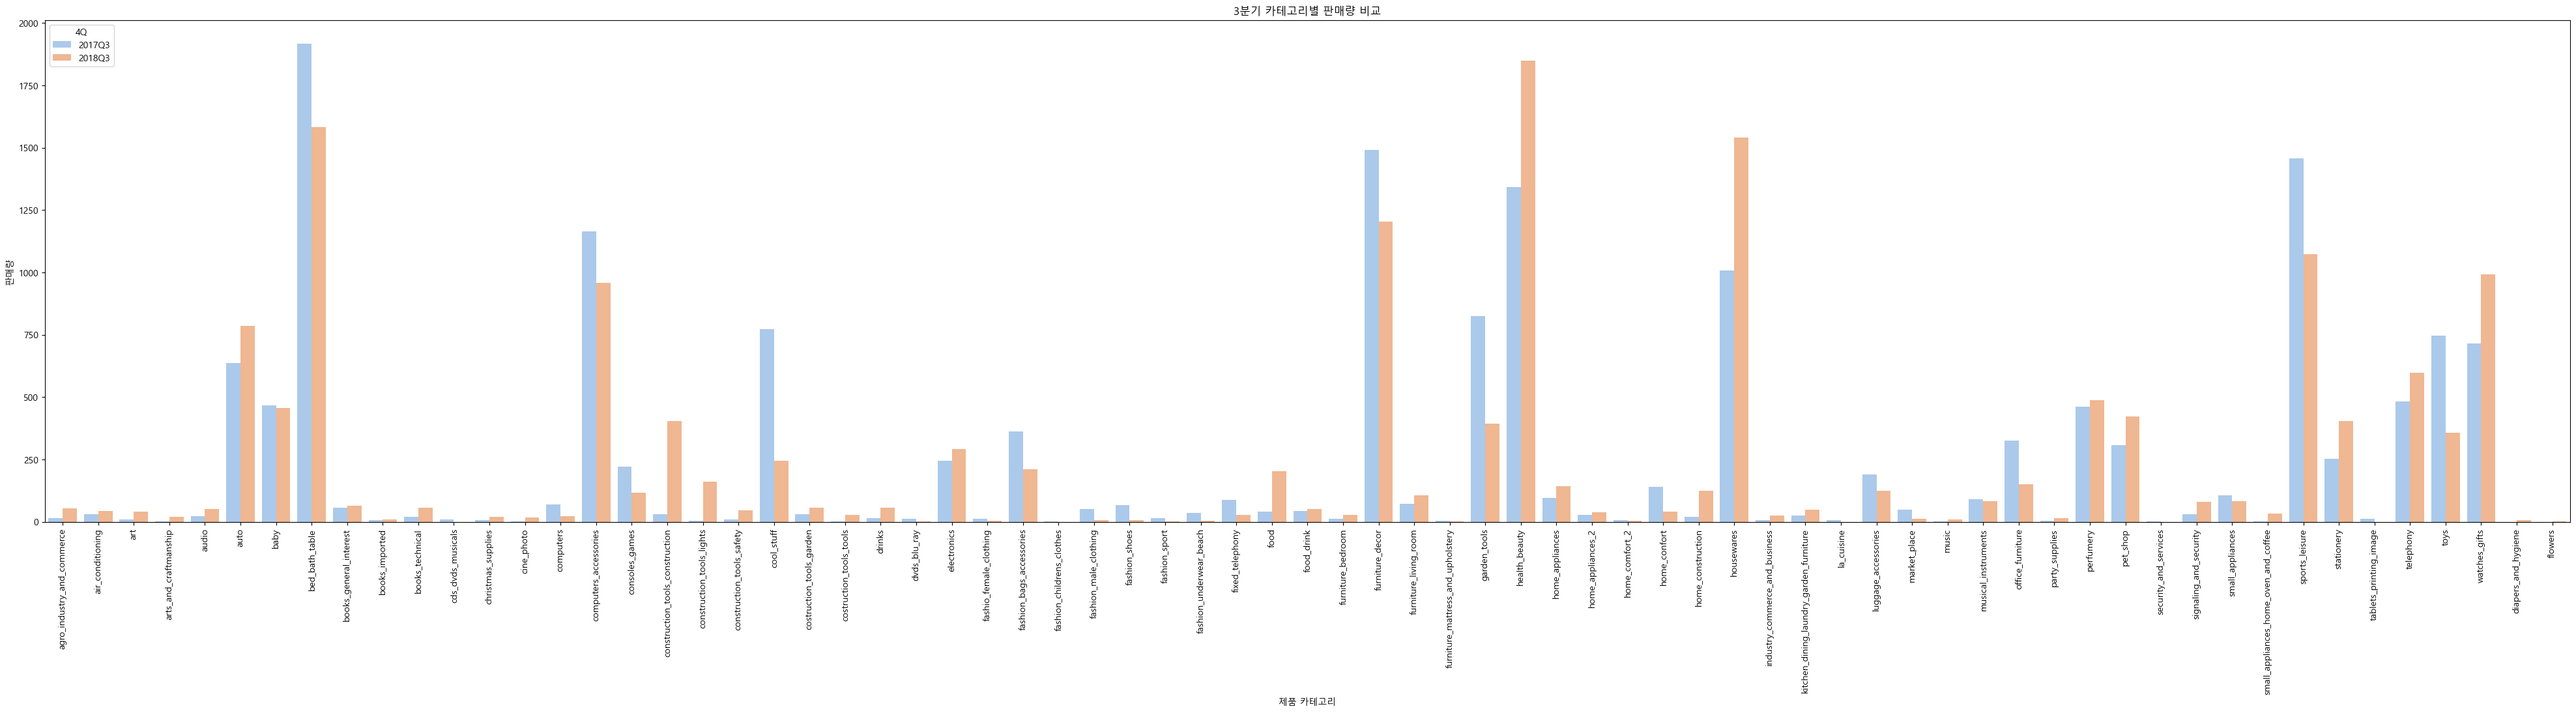

In [27]:
plt.figure(figsize=(50, 10)) 
sns.barplot(data=q_03,x='product_category_name_english',y='order_item_id',hue='4Q')
plt.title('3분기 카테고리별 판매량 비교')
plt.xticks(rotation=90)
plt.xlabel('제품 카테고리')
plt.ylabel('판매량')
plt.show()

### 4분기

In [28]:
# 2017 4분기 vs 2016 4분기
cond4 = (count_4Q_ca['4Q'] == '2017Q4')| (count_4Q_ca['4Q'] == '2016Q4')
q_04 = count_4Q_ca[cond4]
q_04

,4Q,product_category_name_english,order_item_id
2,2016Q4,air_conditioning,18.0
3,2016Q4,audio,2.0
4,2016Q4,auto,9.0
5,2016Q4,baby,13.0
6,2016Q4,bed_bath_table,16.0
...,...,...,...
287,2017Q4,stationery,572.0
288,2017Q4,tablets_printing_image,13.0
289,2017Q4,telephony,1007.0
290,2017Q4,toys,1340.0


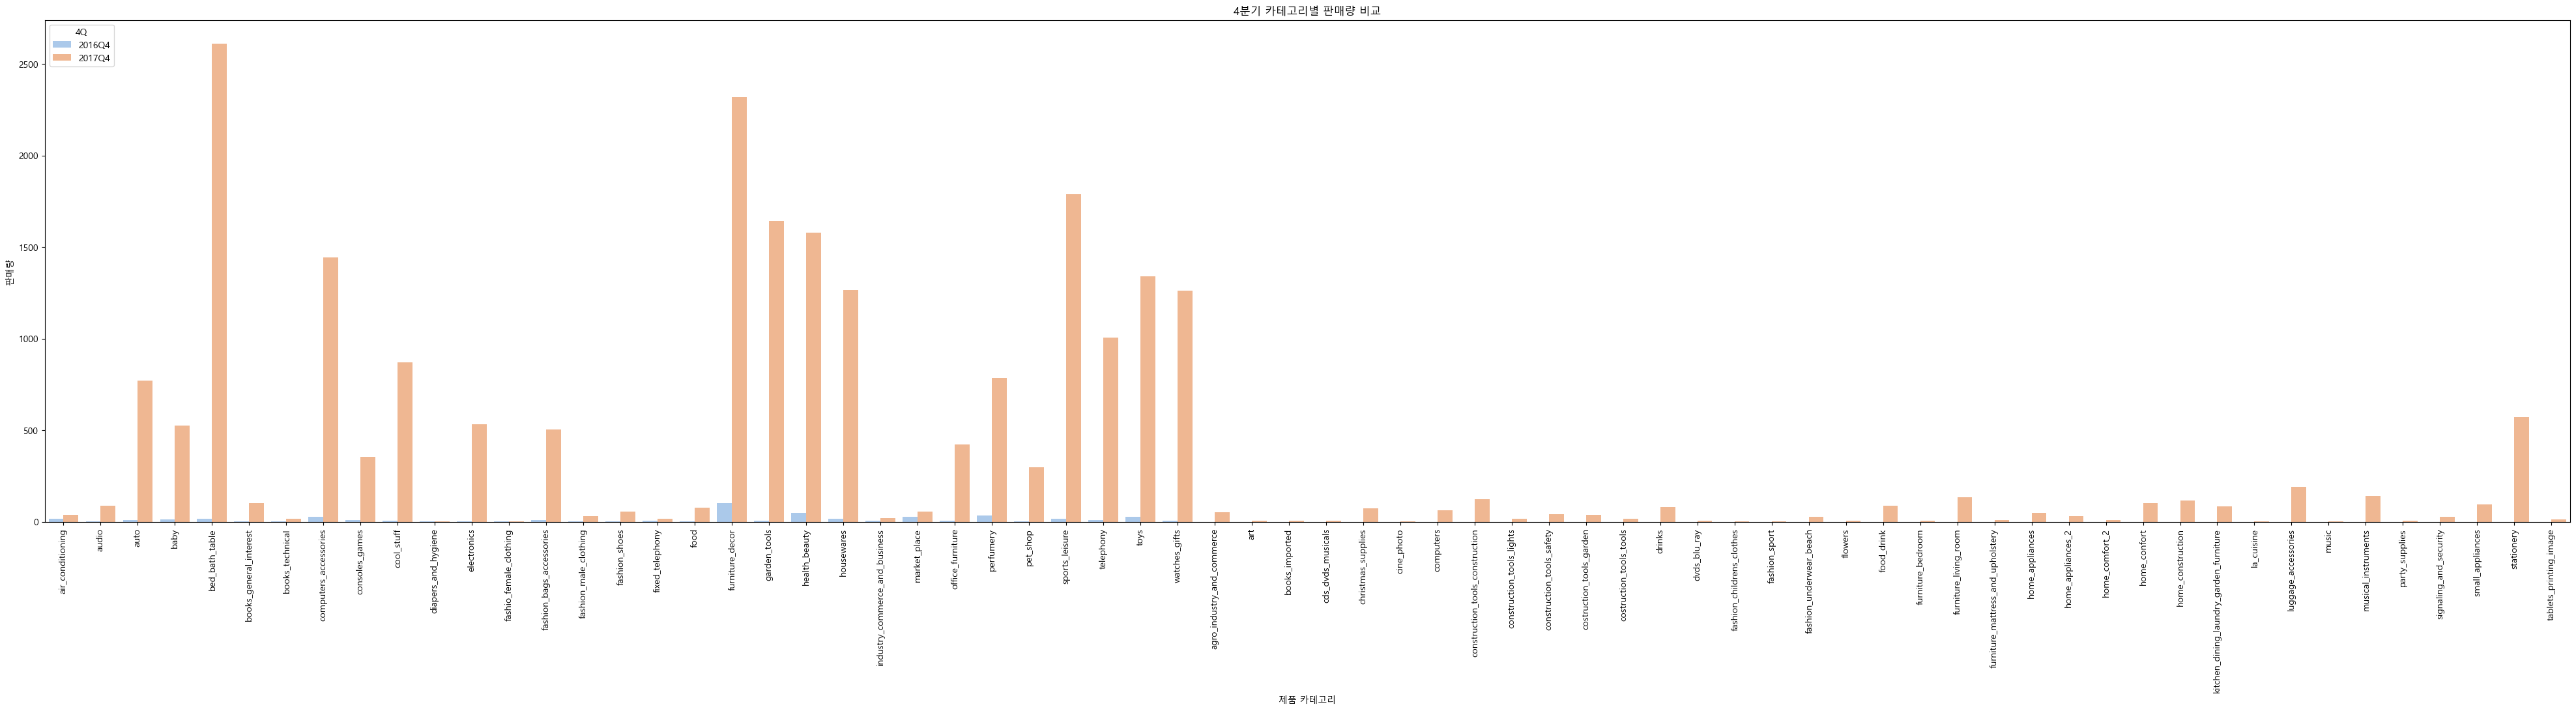

In [29]:
plt.figure(figsize=(50, 10)) 
sns.barplot(data=q_04,x='product_category_name_english',y='order_item_id',hue='4Q')
plt.title('4분기 카테고리별 판매량 비교')
plt.xticks(rotation=90)
plt.xlabel('제품 카테고리')
plt.ylabel('판매량')
plt.show()

==> 2016 년 데이터가 너무 조금밖에 없어서 비교가 안 됨.

==> 년도에 따라 많이 팔리는 제품이 있다.

# 주문 : canceled + unavailable 의 특징

In [30]:
# merge
df1 = pd.merge(orders, order_items, left_on='order_id', right_on='order_id', how='left')
df1 = pd.merge(df1, products, left_on='product_id', right_on='product_id', how='left')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113425 entries, 0 to 113424
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113425 non-null  object 
 1   customer_id                    113425 non-null  object 
 2   order_status                   113425 non-null  object 
 3   order_purchase_timestamp       113425 non-null  object 
 4   order_approved_at              113264 non-null  object 
 5   order_delivered_carrier_date   111457 non-null  object 
 6   order_delivered_customer_date  110196 non-null  object 
 7   order_estimated_delivery_date  113425 non-null  object 
 8   order_item_id                  112650 non-null  float64
 9   product_id                     112650 non-null  object 
 10  seller_id                      112650 non-null  object 
 11  shipping_limit_date            112650 non-null  object 
 12  price                         

In [31]:
# order_status : cancel, unavailable 데이터만 추출
condition = (df1['order_status']=='canceled') | (df1['order_status']=='unavailable')
df1 = df1[condition]

In [32]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1316 entries, 306 to 113397
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       1316 non-null   object 
 1   customer_id                    1316 non-null   object 
 2   order_status                   1316 non-null   object 
 3   order_purchase_timestamp       1316 non-null   object 
 4   order_approved_at              1175 non-null   object 
 5   order_delivered_carrier_date   76 non-null     object 
 6   order_delivered_customer_date  7 non-null      object 
 7   order_estimated_delivery_date  1316 non-null   object 
 8   order_item_id                  549 non-null    float64
 9   product_id                     549 non-null    object 
 10  seller_id                      549 non-null    object 
 11  shipping_limit_date            549 non-null    object 
 12  price                          549 non-null    fl

### 주문 후, 배송완료까지 걸리는 시간

In [33]:
# 데이터 타입: timestamp로 변경
df1['order_purchase_timestamp'] = pd.to_datetime(df1['order_purchase_timestamp'])
df1['order_estimated_delivery_date'] = pd.to_datetime(df1['order_estimated_delivery_date'])
df1['order_approved_at'] = pd.to_datetime(df1['order_approved_at'])

# 평균 배송 시간
df1['delivery_days'] = df1['order_estimated_delivery_date'] - df1['order_purchase_timestamp']
print('canceled + unavailable 평균 예상 배송 시간 : ', df1['delivery_days'].mean())

canceled + unavailable 평균 예상 배송 시간 :  22 days 22:26:33.553191489


In [34]:
# 데이터 타입: timestamp로 변경
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])

# 평균 배송 시간
df['delivery_days'] = df['order_estimated_delivery_date'] - df['order_purchase_timestamp']
print('주문완료 및 배송 완료 평균 예상 배송 시간 : ', df['delivery_days'].mean())

주문완료 및 배송 완료 평균 예상 배송 시간 :  23 days 20:12:01.985701415


In [35]:
# 평균 예상 배송시간 데이터 프레임 만들기
new_row1 = pd.DataFrame({'order_status': ['sales'],'delivery_days':['23 days 20:12:01.985701415']})
new_row2 = pd.DataFrame({'order_status': ['canceled'],'delivery_days':['22 days 22:26:33.553191489']})
delivery_days_group = pd.concat([new_row1, new_row2])
delivery_days_group

,order_status,delivery_days
0,sales,23 days 20:12:01.985701415
0,canceled,22 days 22:26:33.553191489


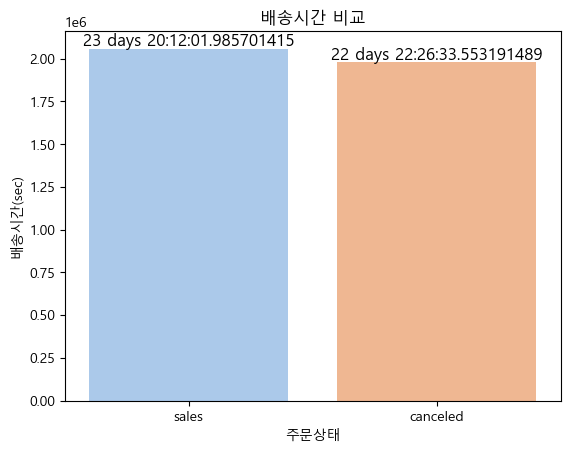

In [36]:
# 문자열을 timedelta로 변환
delivery_days_group['delivery_days'] = pd.to_timedelta(delivery_days_group['delivery_days'])

# timedelta를 초로 변환
delivery_days_group['Seconds'] = delivery_days_group['delivery_days'].dt.total_seconds()

# 막대그래프 그리기
ax = sns.barplot(x=delivery_days_group['order_status'], y=delivery_days_group['Seconds'], data=delivery_days_group)

for i, p in enumerate(ax.patches):
    ax.annotate(f'{delivery_days_group["delivery_days"].iloc[i]}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('배송시간 비교')
plt.xlabel('주문상태')
plt.ylabel('배송시간(sec)')
plt.show()

In [37]:
# cancel, unavailable 나눠서 배송예상시간 평균값
delivery_days_df = pd.DataFrame(df1.groupby('order_status')['delivery_days'].mean().reset_index())
delivery_days_df['delivery_days']=delivery_days_df['delivery_days'].astype('str')

# sales와 합치기
new_row = pd.DataFrame({'order_status': ['sales'],'delivery_days':['23 days 20:12:01.985701415']})
delivery_days_df = pd.concat([new_row,delivery_days_df])
delivery_days_df

,order_status,delivery_days
0,sales,23 days 20:12:01.985701415
0,canceled,22 days 11:10:09.878186968
1,unavailable,23 days 11:29:24.167213114


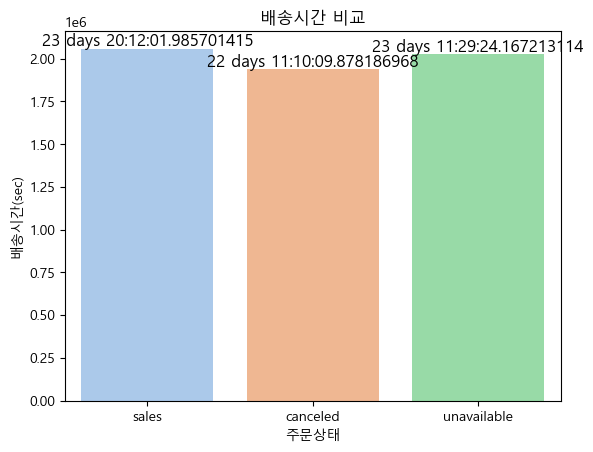

In [38]:
# 문자열을 timedelta로 변환
delivery_days_df['delivery_days'] = pd.to_timedelta(delivery_days_df['delivery_days'])

# timedelta를 초로 변환
delivery_days_df['Seconds'] = delivery_days_df['delivery_days'].dt.total_seconds()

# 막대그래프 그리기
ax = sns.barplot(x=delivery_days_df['order_status'], y=delivery_days_df['Seconds'], data=delivery_days_df)

for i, p in enumerate(ax.patches):
    ax.annotate(f'{delivery_days_df["delivery_days"].iloc[i]}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('배송시간 비교')
plt.xlabel('주문상태')
plt.ylabel('배송시간(sec)')
plt.show()

==> 차이가 없음.(배송지연으로 인행 취소는 아닌 것 같음)

### 주문 후, 판매자의 승인이 있기까지 걸리는 시간

In [39]:
# 승인될때 까지 걸리는 시간
df1['order_approved_days'] = df1['order_approved_at']-df1['order_purchase_timestamp']
print('canceled + unavailable 판매자 승인 평균 시간 : ',df1['order_approved_days'].mean())

canceled + unavailable 판매자 승인 평균 시간 :  0 days 19:31:26.997446808


In [40]:
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['order_approved_days'] = df['order_approved_at']-df['order_purchase_timestamp']
print('주문완료 및 배송 완료 주문의 평균 판매자 승인 시간 평균 : ', df['order_approved_days'].mean())

주문완료 및 배송 완료 주문의 평균 판매자 승인 시간 평균 :  0 days 10:34:14.313634701


In [41]:
# 평균 판매자 승인 시간 데이터 프레임 만들기
new_row1 = pd.DataFrame({'order_status': ['sales'],'order_approved_days':['0 days 10:34:14.313634701']})
new_row2 = pd.DataFrame({'order_status': ['canceled'],'order_approved_days':['0 days 19:31:26.997446808']})
approved_days_group = pd.concat([new_row1, new_row2])
approved_days_group

,order_status,order_approved_days
0,sales,0 days 10:34:14.313634701
0,canceled,0 days 19:31:26.997446808


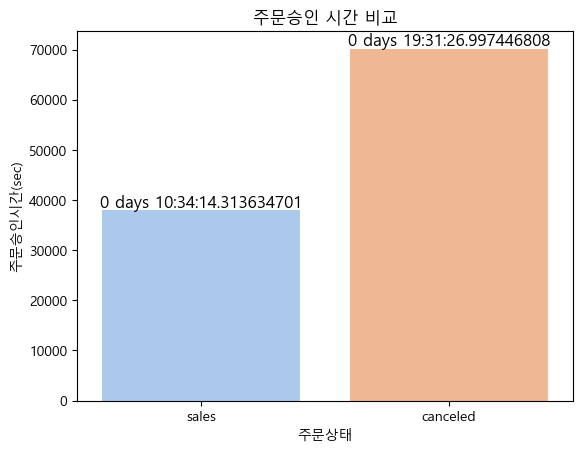

In [42]:
# 문자열을 timedelta로 변환
approved_days_group['order_approved_days'] = pd.to_timedelta(approved_days_group['order_approved_days'])

# timedelta를 초로 변환
approved_days_group['Seconds'] = approved_days_group['order_approved_days'].dt.total_seconds()

# 막대그래프 그리기
ax = sns.barplot(x=approved_days_group['order_status'], y=approved_days_group['Seconds'], data=approved_days_group)


for i, p in enumerate(ax.patches):
    ax.annotate(f'{approved_days_group["order_approved_days"].iloc[i]}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('주문승인 시간 비교')
plt.xlabel('주문상태')
plt.ylabel('주문승인시간(sec)')
plt.show()

==> 주문 승인될때까지의 시간이 실제 구매까지 이어지는데 영향을 줄 수 있을 것으로 보임.

In [43]:
# cancel, unavailable 나눠서 판매자 승인시간 평균값
approved_days_df = pd.DataFrame(df1.groupby('order_status')['order_approved_days'].mean().reset_index())
approved_days_df['order_approved_days']=approved_days_df['order_approved_days'].astype('str')

# sales와 합치기
new_row = pd.DataFrame({'order_status': ['sales'],'order_approved_days':['0 days 10:34:14.313634701']})
approved_days_df = pd.concat([new_row,approved_days_df])
approved_days_df

,order_status,order_approved_days
0,sales,0 days 10:34:14.313634701
0,canceled,0 days 14:16:31.201769911
1,unavailable,1 days 00:23:08.840983606


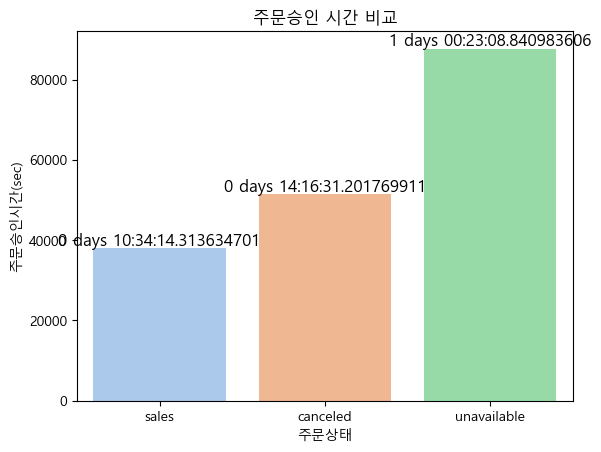

In [44]:
# 문자열을 timedelta로 변환
approved_days_df['order_approved_days'] = pd.to_timedelta(approved_days_df['order_approved_days'])

# timedelta를 초로 변환
approved_days_df['Seconds'] = approved_days_df['order_approved_days'].dt.total_seconds()

ax = sns.barplot(x=approved_days_df['order_status'], y=approved_days_df['Seconds'], data=approved_days_df)

for i, p in enumerate(ax.patches):
    ax.annotate(f'{approved_days_df["order_approved_days"].iloc[i]}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('주문승인 시간 비교')
plt.xlabel('주문상태')
plt.ylabel('주문승인시간(sec)')
plt.show()

# 리뷰와 배송시간 사이의 관계 

In [45]:
reviews = pd.read_csv('olist_order_reviews_dataset.csv')

In [46]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [47]:
# merge
df = pd.merge(df,reviews, left_on='order_id',right_on='order_id', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112769 entries, 0 to 112768
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype          
---  ------                         --------------   -----          
 0   order_id                       112769 non-null  object         
 1   customer_id                    112769 non-null  object         
 2   order_status                   112769 non-null  object         
 3   order_purchase_timestamp       112769 non-null  datetime64[ns] 
 4   order_approved_at              112749 non-null  datetime64[ns] 
 5   order_delivered_carrier_date   112035 non-null  object         
 6   order_delivered_customer_date  110832 non-null  object         
 7   order_estimated_delivery_date  112769 non-null  datetime64[ns] 
 8   order_item_id                  112761 non-null  float64        
 9   product_id                     112761 non-null  object         
 10  seller_id                      112761 non-null  object  

In [48]:
# 배송시간 예측
df['order_approved_at']=pd.to_datetime(df['order_approved_at'])
df['order_delivered_customer_date']=pd.to_datetime(df['order_delivered_customer_date'])
df['delivery_time'] = df['order_delivered_customer_date'] - df['order_approved_at']

In [49]:
# 주문부터 배송완료까지 걸리는 시간, 리뷰점수 컬럼만 추출
review_deliver = df[['delivery_time','review_score']]

# 그래프 그리기 가능하도록 초단위 시간으로 변경
review_deliver['delivery_time_sec'] = review_deliver['delivery_time'].dt.total_seconds()
review_deliver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112769 entries, 0 to 112768
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype          
---  ------             --------------   -----          
 0   delivery_time      110817 non-null  timedelta64[ns]
 1   review_score       111842 non-null  float64        
 2   delivery_time_sec  110817 non-null  float64        
dtypes: float64(2), timedelta64[ns](1)
memory usage: 2.6 MB


C:\Users\kyha9\AppData\Local\Temp\ipykernel_21348\1591867884.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_deliver['delivery_time_sec'] = review_deliver['delivery_time'].dt.total_seconds()


In [50]:
review_deliver = review_deliver.dropna()

In [51]:
review_deliver.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109990 entries, 0 to 112768
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype          
---  ------             --------------   -----          
 0   delivery_time      109990 non-null  timedelta64[ns]
 1   review_score       109990 non-null  float64        
 2   delivery_time_sec  109990 non-null  float64        
dtypes: float64(2), timedelta64[ns](1)
memory usage: 3.4 MB


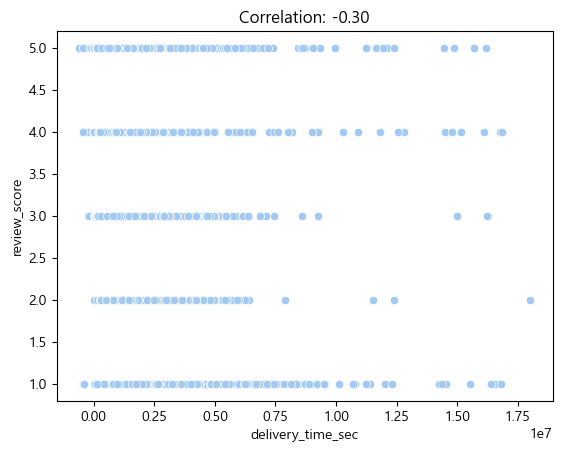

상관관계: -0.30311


In [52]:
correlation = review_deliver['delivery_time_sec'].corr(review_deliver['review_score'])

# 상관관계 시각화
sns.scatterplot(x='delivery_time_sec', y='review_score', data=review_deliver)
plt.title(f'Correlation: {correlation:.2f}')
plt.show()

print(f'상관관계: {correlation:.5f}')

In [53]:
from scipy.stats import pearsonr

# 상관계수와 p-value 계산
correlation_coefficient, p_value = pearsonr(review_deliver['delivery_time_sec'], review_deliver['review_score'])


print(f"P-value: {p_value}")


alpha = 0.05

if p_value < alpha:
    print("귀무가설 기각: 두 변수 간의 상관관계는 통계적으로 유의미합니다.")
else:
    print("귀무가설 채택: 두 변수 간의 상관관계는 통계적으로 유의미하지 않습니다.")

P-value: 0.0
귀무가설 기각: 두 변수 간의 상관관계는 통계적으로 유의미합니다.


평점과 배송시간과의 상관관계 : -0.30311
==> 평점과 배송시간과는 상관관계 통계적으로 유의하다.

# 평균 평점

In [54]:
# 전체 리뷰 평균
df['review_score'].mean()

4.044035335562668

In [55]:
# merge, 판매량 가장 많은 제품 10개와 그에 대한 리뷰 평점
top10_product_merge = pd.merge(df,top10_product,left_on='product_category_name_english',right_on='product_category_name_english', how='inner')

In [56]:
top10_product_merge['review_score'].mean()

4.018010809293185

==> 전체리뷰평점 : 4.044035335562668, 판매량 상위 10개 상품카테고리의 평점: 4.018010809293185
- 판매량이 많은 제품 카테고리라고 해서 리뷰 평점이 높은 것이 아니다.